In [1]:
import pandas as pd

### 시각화 라이브러리 정의
# - 파이썬에서 사용되는 기본 시각화 라이브러리
import matplotlib.pyplot as plt

# - 히트맵 라이브러리
import seaborn as sns
import geopandas as gpd
import folium
from shapely.geometry import Polygon

import os
from dask.diagnostics import ProgressBar
import dask.dataframe as dd


### 한글처리
plt.rc("font", family="Malgun Gothic")

# - 마이너스 기호 깨짐 처리
plt.rcParams["axes.unicode_minus"] = False

In [3]:
# dtype 매개변수를 사용하여 각 열의 데이터 타입을 명시적으로 지정
merged_wildfire_df = dd.read_csv(
    "./USA data/merged_wildfire_weather.csv", 
    dtype={'version': 'object'}  # version 열은 문자열로 처리
)

# Dask 데이터프레임의 info()와 head() 확인
print(merged_wildfire_df.head())  # compute()를 사용하지 않으면 미리보기만 가능

# Dask로 데이터 타입 변환
merged_wildfire_df['datetime'] = dd.to_datetime(merged_wildfire_df['datetime'])

# 결측치 확인
print(merged_wildfire_df.isnull().sum().compute())  # .compute()로 실제 값 계산

# 불필요한 컬럼 삭제
columns_to_drop = [
    'scan', 'track', 'satellite', 'instrument', 'version', 'type'
]

merged_wildfire_df = merged_wildfire_df.drop(columns=columns_to_drop)

   latitude  longitude  brightness  scan  track    acq_date satellite  \
0  40.12655  -80.99725      322.99  0.42   0.61  2015-01-01         N   
1  40.75163  -81.44097      335.90  0.45   0.63  2015-01-01         N   
2  39.93786  -76.81354      301.80  0.51   0.49  2015-01-01         N   
3  37.23229  -82.03670      295.38  0.46   0.64  2015-01-01         N   
4  36.35398  -76.80887      301.27  0.46   0.47  2015-01-01         N   

  instrument confidence version  bright_t31   frp daynight  type   T2M  WS2M  \
0      VIIRS          n       2      265.48  3.25        N   0.0  1.23  0.66   
1      VIIRS          n       2      264.78  3.97        N   0.0  1.23  0.66   
2      VIIRS          n       2      267.25  0.80        N   2.0  1.23  0.66   
3      VIIRS          n       2      268.12  0.83        N   2.0  1.23  0.66   
4      VIIRS          n       2      272.02  1.35        N   2.0  1.23  0.66   

    RH2M  PRECTOTCORR             datetime  
0  43.37          0.0  2015-01-01 0

In [ ]:
# 결측치 확인
print(merged_wildfire_df.isnull().sum().compute())  # 다시 계산하여 확인

latitude       0
longitude      0
brightness     0
acq_date       0
confidence     0
bright_t31     0
frp            0
daynight       0
T2M            0
WS2M           0
RH2M           0
PRECTOTCORR    0
datetime       0
dtype: int64


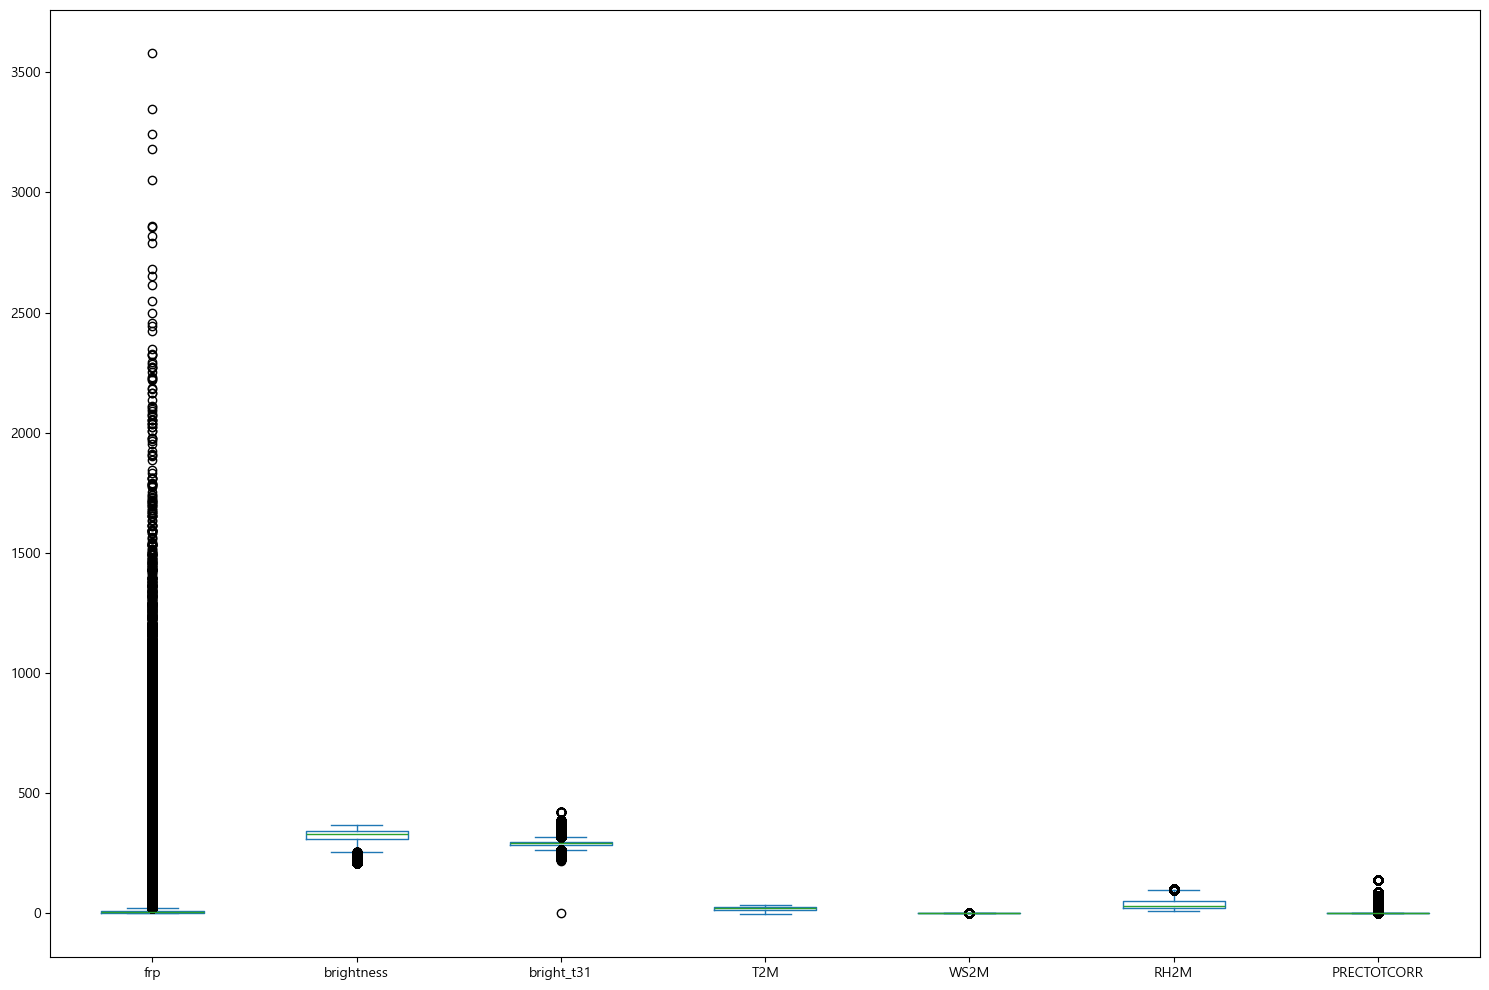

In [5]:
# Boxplot 그리기 (Dask는 Pandas처럼 plotting 직접 지원하지 않음, pandas로 변환 후 plotting)
merged_wildfire_df.compute()[["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]].plot(kind='box', figsize=(15, 10))
plt.tight_layout()
plt.show()


In [6]:
# IQR 계산 및 이상치 처리
def calculate_iqr(df, columns):
    iqr_results = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        iqr_results[col] = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outliers Count': len(outliers),
            'Outliers': outliers
        }
    
    return iqr_results

columns_to_check = ["frp", "brightness", "bright_t31", "T2M", "WS2M", "RH2M", "PRECTOTCORR"]
# Dask에서는 compute()를 호출해야 실제 연산이 이루어짐
merged_df = merged_wildfire_df.compute()  # Dask 데이터프레임을 pandas로 변환

iqr_results = calculate_iqr(merged_df, columns_to_check)
for col, result in iqr_results.items():
    print(f"Column: {col}")
    print(f"  Q1: {result['Q1']}")
    print(f"  Q3: {result['Q3']}")
    print(f"  IQR: {result['IQR']}")
    print(f"  Lower Bound: {result['Lower Bound']}")
    print(f"  Upper Bound: {result['Upper Bound']}")
    print(f"  Outliers Count: {result['Outliers Count']}")
    print("")


Column: frp
  Q1: 1.65
  Q3: 9.42
  IQR: 7.77
  Lower Bound: -10.004999999999999
  Upper Bound: 21.075
  Outliers Count: 1053868

Column: brightness
  Q1: 307.4
  Q3: 342.71
  IQR: 35.31
  Lower Bound: 254.43499999999997
  Upper Bound: 395.67499999999995
  Outliers Count: 8139

Column: bright_t31
  Q1: 285.04
  Q3: 298.4
  IQR: 13.359999999999957
  Lower Bound: 265.0000000000001
  Upper Bound: 318.43999999999994
  Outliers Count: 282682

Column: T2M
  Q1: 12.19
  Q3: 26.14
  IQR: 13.950000000000001
  Lower Bound: -8.735000000000001
  Upper Bound: 47.065
  Outliers Count: 0

Column: WS2M
  Q1: 0.78
  Q3: 0.96
  IQR: 0.17999999999999994
  Lower Bound: 0.5100000000000001
  Upper Bound: 1.23
  Outliers Count: 209072

Column: RH2M
  Q1: 22.02
  Q3: 52.08
  IQR: 30.06
  Lower Bound: -23.069999999999997
  Upper Bound: 97.16999999999999
  Outliers Count: 46886

Column: PRECTOTCORR
  Q1: 0.0
  Q3: 0.04
  IQR: 0.04
  Lower Bound: -0.06
  Upper Bound: 0.1
  Outliers Count: 1822330



In [7]:
# 이상치 처리 함수
def handle_outliers(df):
    df['frp'] = df['frp'].clip(lower=0)
    df['brightness'] = df['brightness'].clip(lower=254.43, upper=395.67)
    df['bright_t31'] = df['bright_t31'].clip(lower=265.0, upper=318.44)
    df['WS2M'] = df['WS2M'].clip(upper=1.23)
    df['RH2M'] = df['RH2M'].clip(upper=100)
    return df

# 이상치 처리
cleaned_wildfire_df = handle_outliers(merged_df)

# 처리 후 데이터 확인
print(cleaned_wildfire_df[['frp', 'brightness', 'bright_t31', 'T2M', 'WS2M', 'RH2M', 'PRECTOTCORR']].head())



    frp  brightness  bright_t31   T2M  WS2M   RH2M  PRECTOTCORR
0  3.25      322.99      265.48  1.23  0.66  43.37          0.0
1  3.97      335.90      265.00  1.23  0.66  43.37          0.0
2  0.80      301.80      267.25  1.23  0.66  43.37          0.0
3  0.83      295.38      268.12  1.23  0.66  43.37          0.0
4  1.35      301.27      272.02  1.23  0.66  43.37          0.0


<Axes: xlabel='daynight', ylabel='frp'>

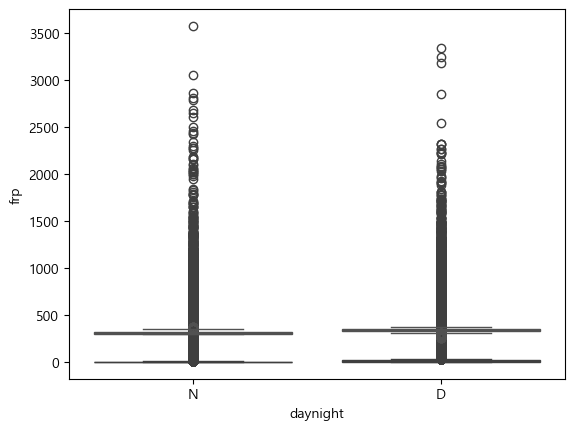

In [8]:
# Boxplot
sns.boxplot(x="daynight", y="frp", data=cleaned_wildfire_df)
sns.boxplot(x="daynight", y="brightness", data=cleaned_wildfire_df)


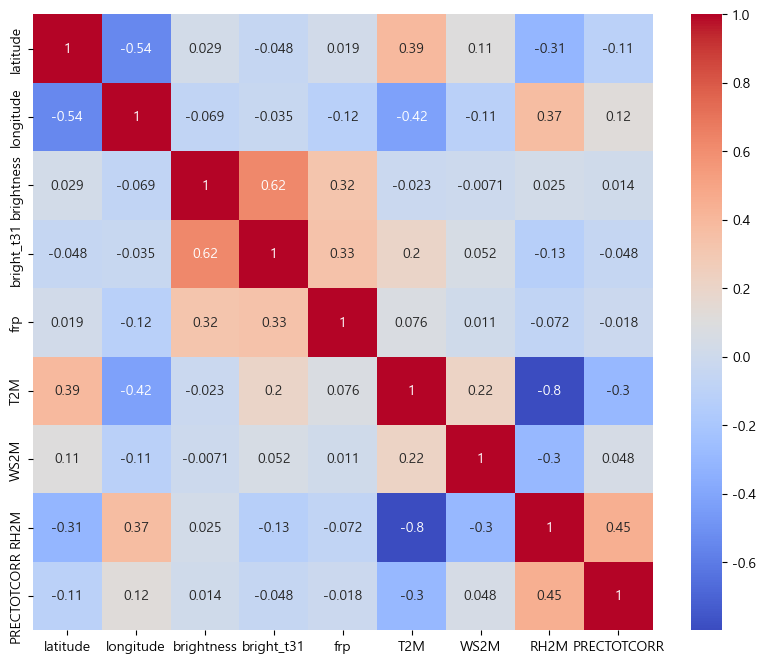

In [9]:
# 상관 관계 시각화
corr = cleaned_wildfire_df.drop(columns=["acq_date", "confidence", "daynight", "datetime"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


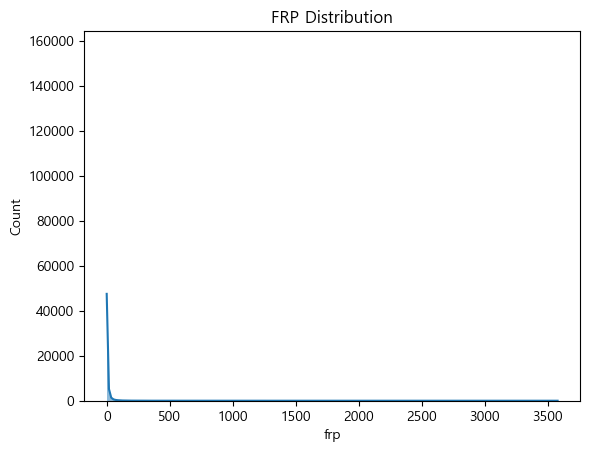

In [10]:
# FRP 분포
sns.histplot(cleaned_wildfire_df['frp'], kde=True)
plt.title("FRP Distribution")
plt.show()


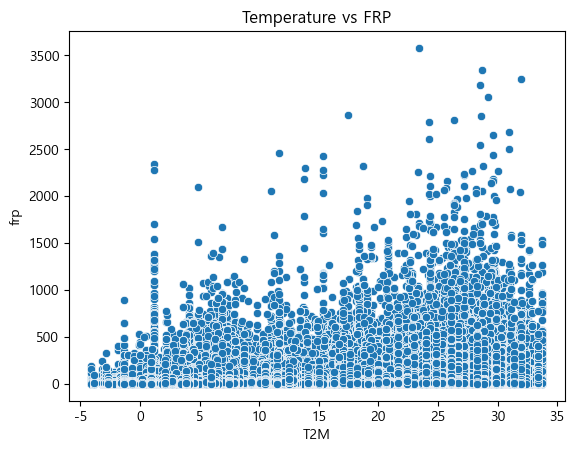

In [11]:
# FRP와 T2M의 관계
sns.scatterplot(x="T2M", y="frp", data=cleaned_wildfire_df)
plt.title("Temperature vs FRP")
plt.show()